In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2

import numpy as np
from scipy.cluster.vq import kmeans, vq
from scipy.optimize import minimize
from sklearn.linear_model import Lasso, Ridge
from sklearn.cluster import SpectralClustering
from sklearn.decomposition import PCA

from scipy.spatial.distance import cdist
from skimage.restoration import denoise_nl_means, estimate_sigma

In [2]:
import jax.numpy as jnp
import cr.sparse as crs
from cr.sparse import lop
from cr.sparse.cvx.adm import yall1

K means clustering on tiles taken from an image

(480, 640)


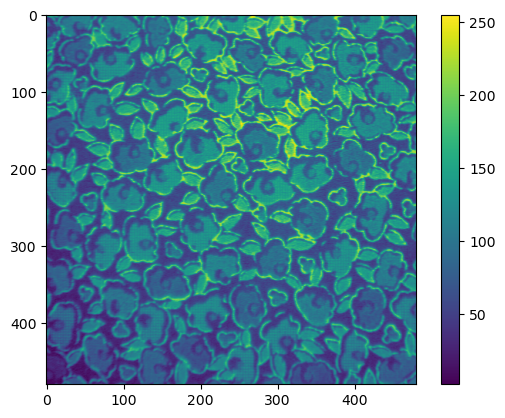

In [3]:
image_number = 10
# dimensionality (N) of subspace = 64
tile_w = 8
 

image = cv2.imread(f"Dataset/Image{image_number}.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
print(image.shape)
mindim = np.min(image.shape)
image = image[:mindim, :mindim]

plt.imshow(image)
plt.colorbar()
plt.show();

In [4]:
def return_tiles(image, tile_width):
    """
    image: A 2D array
    tile_width: the width of a square tile
    """
    width, height = image.shape

    # Calculate the number of tiles in each dimension
    num_tiles_x = width // tile_width
    num_tiles_y = height // tile_width

    # Initialize an empty array to store tiles
    # Reshape the image into tiles
    tiles = image[:num_tiles_y * tile_width, :num_tiles_x * tile_width].reshape(
        num_tiles_y, tile_width, num_tiles_x, tile_width)

    # Transpose the axes to get the desired shape
    tiles2d = tiles.transpose(0, 2, 1, 3).reshape(num_tiles_y, num_tiles_x, tile_width, tile_width)
    tiles1d = tiles2d.reshape(num_tiles_y*num_tiles_x, tile_width*tile_width)

    return tiles2d, tiles1d

In [5]:
# The data vector
im_tiles2d, im_tiles1d = return_tiles(image, tile_w)
print(im_tiles2d.shape)
print(im_tiles1d.shape)

(60, 60, 8, 8)
(3600, 64)


In [6]:
def visualize_tiles(tiles_array):
    num_tiles_y, num_tiles_x, tile_width, _ = tiles_array.shape

    #subplot with a grid of tiles
    fig, axes = plt.subplots(num_tiles_y, num_tiles_x, figsize=(10, 10))

    # Iterate through each tile and display
    for i in range(num_tiles_y):
        for j in range(num_tiles_x):
            axes[i, j].imshow(tiles_array[i, j, :, :])
            axes[i, j].axis('off')  # Turn off axis labels

    plt.show()

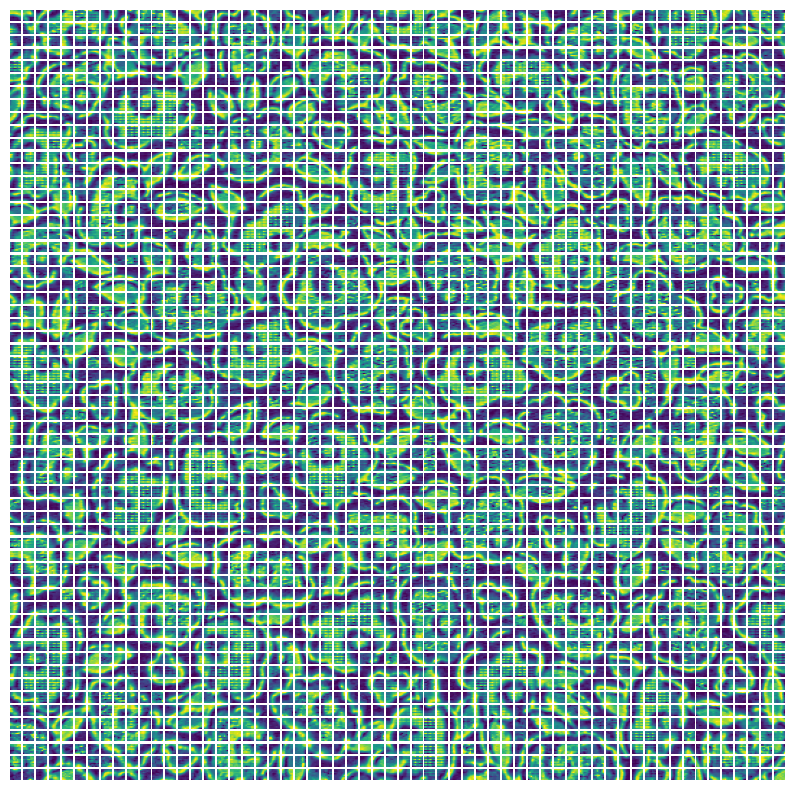

In [7]:
visualize_tiles(im_tiles2d)

In [8]:
im_tiles1d = im_tiles1d.astype(float)

### Decide the number of clusters
* And if needed, change the num_clusters argument in the start 

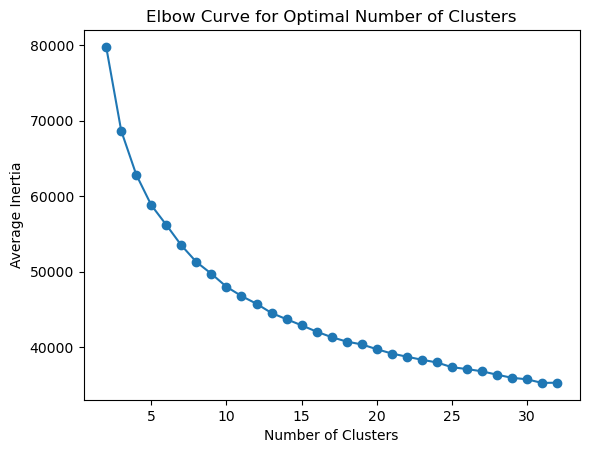

[79788.67667828541,
 68663.56566865557,
 62844.377912426324,
 58804.27411319963,
 56184.0796584087,
 53475.656757089055,
 51266.55898798378,
 49704.21405366256,
 47983.660383572904,
 46753.94502781494,
 45729.80870976357,
 44503.6110980805,
 43676.3553906036,
 42870.273937534155,
 42027.397818291734,
 41299.6349400801,
 40709.69357263773,
 40338.66642799029,
 39702.69894642238,
 39128.085816036444,
 38708.305559933855,
 38303.27230898604,
 37943.78307794529,
 37315.87414528467,
 37064.30589718161,
 36770.339126480045,
 36319.192937906795,
 35908.85164983785,
 35705.307797466434,
 35228.94809081269,
 35259.366112120595]

In [9]:
def calculate_inertia(data, centroids, cluster_indices):
    # Calculate within-cluster sum of squared distances
    # print(type(cluster_indices), cluster_indices.shape)
    distances = np.sum((data - centroids[cluster_indices]) ** 2)
    inertia = distances / len(data)
    return inertia

def elbow_method(data, max_clusters=32):
    inertias = []

    for num_clusters in range(2, max_clusters + 1):
        centroids, distortion = kmeans(data, num_clusters)
        cluster_indices, _ = vq(data, centroids)
        inertia = calculate_inertia(data, centroids, cluster_indices)
        inertias.append(inertia)

    plt.plot(range(2, max_clusters + 1), inertias, marker='o')
    plt.title('Elbow Curve for Optimal Number of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Average Inertia')
    plt.show()

    return inertias

elbow_method(im_tiles1d, 32)

In [10]:
num_clusters = 20 

In [11]:
# Perform Clustering

def getKmeans(data, num_clusters):
    # Adjust the number of clusters as needed
    centroids, _ = kmeans(data, num_clusters)
    print('data dimensions:', data.shape)
    print('number of clusters:', num_clusters)
    print('centroids shape:', centroids.shape)

    #vector quatization
    cluster_indices, _ = vq(data, centroids)
    print('cluster_indices shape:', cluster_indices.shape)
    return cluster_indices

cluster_indices = getKmeans(im_tiles1d, num_clusters)

data dimensions: (3600, 64)
number of clusters: 20
centroids shape: (20, 64)
cluster_indices shape: (3600,)


In [12]:
def getRobustSSCV1(Y, lmbda):
    """
    Robust Subspace Clustering: Candes, Sankoltanobi
    no affine constraint
    has beta_i = 0 constraint
    """
    # Step 1: Compute sparse coefficients
    N, n = Y.shape
    
    B = np.zeros((N, N))
    for i in range(N):
        print('%.d th cluster done'%(i))
        y_i = Y[i, :]

        # Define the objective function and constraints
        def objective_function(beta):
            return np.linalg.norm(y_i - np.dot(beta, Y))**2 + lmbda * np.linalg.norm(beta, ord=1)

        # Define the equality constraint beta_i = 0
        def equality_constraint(beta):
            return beta[i]

        # Solve the optimization problem
        initial_guess = np.zeros(N)
        bounds = [(None, None) for _ in range(N)]  # No bounds for beta
        constraints = {'type': 'eq', 'fun': equality_constraint}
        res = minimize(objective_function, initial_guess, method='SLSQP', bounds=bounds, constraints=constraints)
        beta_i = res.x
        
        B[i, :] = np.abs(beta_i)
    
    # Step 2: Construct similarity graph
    W = np.abs(B) + np.abs(B.T)
    
    # Step 3: Compute degree matrix
    D = np.diag(np.sum(W, axis=1))
    
    # Step 4: Compute normalized Laplacian
    D_sqrt_inv = np.linalg.inv(np.sqrt(D))
    L_norm = D_sqrt_inv @ (D - W) @ D_sqrt_inv
    
    # Step 5: Spectral clustering
    spectral_clustering = SpectralClustering(n_clusters='auto', affinity='precomputed', random_state=0)
    labels = spectral_clustering.fit_predict(L_norm)
   
    return labels

# robust_cluster_indices = getRobustSSCV1(im_tiles1d, lmbda=0.5)
# print('robust_cluster_indices shape:', robust_cluster_indices.shape)

In [6]:
def getRobustSSCV2(Y, lmbda):
    """
    Robust Subspace Clustering: Candes, Sankoltanobi
    has affine constraint
    no beta_i = 0 constraint
    """
    # Step 1: Compute sparse coefficients
    N, n = Y.shape
    
    B = np.zeros((N, N))
    for i in range(N):
        print('%.d th cluster done'%(i))
        y_i = Y[i, :]

        # Define the objective function and constraints
        def objective_function(beta):
            return np.linalg.norm(y_i - np.dot(beta, Y))**2 + lmbda * np.linalg.norm(beta, ord=1)

        # Define the affine constraint sum(beta_i) = 1
        def equality_constraint(beta):
            return np.sum(beta) - 1

        # Solve the optimization problem
        initial_guess = np.zeros(N)
        bounds = [(None, None) for _ in range(N)]  # No bounds for beta
        constraints = {'type': 'eq', 'fun': equality_constraint}
        res = minimize(objective_function, initial_guess, method='SLSQP', bounds=bounds, constraints=constraints)
        beta_i = res.x
        
        B[i, :] = np.abs(beta_i)
    
    # Step 2: Construct similarity graph
    W = np.abs(B) + np.abs(B.T)
    
    # Step 3: Compute degree matrix
    D = np.diag(np.sum(W, axis=1))
    
    # Step 4: Compute normalized Laplacian
    D_sqrt_inv = np.linalg.inv(np.sqrt(D))
    L_norm = D_sqrt_inv @ (D - W) @ D_sqrt_inv
    
    # Step 5: Spectral clustering
    spectral_clustering = SpectralClustering(n_clusters='auto', affinity='precomputed', random_state=0)
    labels = spectral_clustering.fit_predict(L_norm)
   
    return labels

robust_cluster_indices = getRobustSSCV2(im_tiles1d, lmbda=0.5)
print('robust_cluster_indices shape:', robust_cluster_indices.shape)

ith cluster done


In [39]:
def getRobustSSCV3(Y, lmbda):
    """
    Robust Subspace Clustering: Candes, Sankoltanobi
    no affine constraint, no beta_i=0 constraint
    """
    # Step 1: Compute sparse coefficients
    N, n = Y.shape
    
    B = np.zeros((N, N))

    # Iterative solution: Error when some L_norms are fitted
    # for i in range(N):
    #     y_i = Y[i, :]

    #     # Define the objective function
    #     # Fit Lasso regression
    #     lasso = Lasso(alpha=lmbda, fit_intercept=False)
    #     lasso.fit(Y.T, y_i.T)
    #     beta_i = lasso.coef_
        
    #     B[i, :] = beta_i

    #Vectorized- Ridge and LASSO
    ridge = Ridge(alpha=lmbda, fit_intercept=False)
    ridge.fit(Y.T, Y.T)
    B = ridge.coef_
    print(B.shape)
    print(B[:10,:10])

    # Step 2: Construct similarity graph
    W = np.abs(B) + np.abs(B.T)
    
    # Step 3: Compute degree matrix
    D = np.diag(np.sum(W, axis=1))
    
    # Step 4: Compute normalized Laplacian
    D_sqrt_inv = np.linalg.inv(np.sqrt(D))
    L_norm = D_sqrt_inv @ (D - W) @ D_sqrt_inv
    
    # Step 5: Spectral clustering
    spectral_clustering = SpectralClustering(n_clusters=20, affinity='precomputed', random_state=0)
    labels = spectral_clustering.fit_predict(L_norm)
   
    return labels

robust_cluster_indices = getRobustSSCV3(im_tiles1d, lmbda=0.5)
print('robust_cluster_indices shape:', robust_cluster_indices.shape)

(3600, 3600)
[[ 1.23767290e-02  2.34758099e-03  2.15244252e-03  9.60434799e-04
   6.65103942e-05  7.29755624e-04 -6.75722416e-05  7.46202238e-04
  -1.38447400e-03 -2.21191867e-03]
 [ 2.34758099e-03  1.38700408e-02  2.19759300e-03 -5.44414410e-04
   3.21676214e-04  4.93225665e-04  8.42524410e-04 -5.82606750e-04
  -1.53632396e-03 -1.15297761e-03]
 [ 2.15244252e-03  2.19759300e-03  1.79941388e-02 -3.85179510e-04
   1.88794913e-04  2.79931394e-04 -4.26068366e-04 -1.34861386e-04
  -6.26814490e-04 -1.89781197e-03]
 [ 9.60434799e-04 -5.44414410e-04 -3.85179510e-04  7.37764335e-03
  -1.10096563e-03 -2.17545638e-04  4.31437992e-05 -7.60462386e-04
  -3.21329809e-04 -5.60097037e-04]
 [ 6.65103942e-05  3.21676214e-04  1.88794913e-04 -1.10096563e-03
   4.21924226e-03  7.33390280e-04  3.93301251e-04  8.66469212e-04
   1.01545912e-03  1.88122225e-03]
 [ 7.29755624e-04  4.93225665e-04  2.79931394e-04 -2.17545638e-04
   7.33390280e-04  2.89477619e-03  7.65728648e-04  1.03111300e-03
   7.72813154e-04  1

c:\Users\thari\anaconda3\envs\FM\lib\site-packages\scipy\sparse\csgraph\_laplacian.py:546: RuntimeWarning: invalid value encountered in sqrt
  w = np.where(isolated_node_mask, 1, np.sqrt(w))


ValueError: array must not contain infs or NaNs

I had another version of RobustSSCV4 earlier without an affine constraint, but just trying to see if I can get a better clustering by indirectly having the $\beta_i = 0$ subspace constraint (By removing the vectors in to have a search in the )

In [11]:
def getRobustSSCV4(Y, lmbda):
    """
    Robust Subspace Clustering: Candes, Sankoltanobi
    with/without affine constraint
    has beta_i = 0 constraint in a second way
    """
    # Step 1: Compute sparse coefficients
    N, n = Y.shape
    #3600,64

    B = np.zeros((N, N))
    for i in range(N):
        print('%.d th cluster start'%(i))
        y_i = Y[i, :]
        
        # Remove the i-th row from Y
        y_others = np.delete(Y, i, axis=0)
        # print(y_others.shape) #3599,64

        # Define the objective function
        def objective_function(beta):
            # Without inserting a zero at the i-th position of the resulting coefficient vector
            return np.linalg.norm(y_i - np.dot(beta, y_others))**2 + lmbda * np.linalg.norm(beta, ord=1)
        
        # Define the affine constraint sum(beta_i) = 1
        def equality_constraint(beta):
            return np.sum(beta) - 1

        # Solve the optimization problem
        initial_guess = np.zeros(N - 1)
        bounds = [(None, None) for _ in range(N - 1)]  # No bounds for beta
        constraints = {'type': 'eq', 'fun': equality_constraint}
        res = minimize(objective_function, initial_guess, method='SLSQP', bounds=bounds, constraints=constraints)
        beta_i = np.insert(res.x, i, 0)  # Insert zero at the i-th position
        
        B[i, :] = np.abs(beta_i)
    
    # Step 2: Construct similarity graph
    W = np.abs(B) + np.abs(B.T)
    
    # Step 3: Compute degree matrix
    D = np.diag(np.sum(W, axis=1))
    
    # Step 4: Compute normalized Laplacian
    D_sqrt_inv = np.linalg.inv(np.sqrt(D))
    L_norm = D_sqrt_inv @ (D - W) @ D_sqrt_inv
    
    # Step 5: Spectral clustering
    spectral_clustering = SpectralClustering(n_clusters='auto', affinity='precomputed', random_state=0)
    labels = spectral_clustering.fit_predict(L_norm)
   
    return labels

robust_cluster_indices = getRobustSSCV4(im_tiles1d, lmbda=0.5)
print('robust_cluster_indices shape:', robust_cluster_indices.shape)

0 th cluster done
(3599, 64)
1 th cluster done
(3599, 64)


KeyboardInterrupt: 

In [1]:
def getRobustSSCV5(Y, sigma):
    """
    Robust Subspace Clustering: Candes, Sankoltanobi
    Other solvers--> cr sparse
    without affine constraint
    has beta_i = 0 constraint in a second way
    """
    # Step 1: Compute sparse coefficients
    N, n = Y.shape
    #3600,64


    B = np.zeros((N, N))
    for i in range(N):
        if i%10 == 0:
            print('%.d th cluster start'%(i))
        y_i = Y[i, :]
        
        # Remove the i-th row from Y
        y_others = np.delete(Y, i, axis=0)
        # print(y_others.shape) # (N-1,n) = 3599,64

        A = y_others.T # (n,N-1)
        T = lop.real_matrix(A)
        T = lop.jit(T)
        
        b = jnp.asarray(y_i.T) #(n,1)
        sol = yall1.solve(T, b, rho=sigma)

        # print(type(sol.x)) --> <class 'jaxlib.xla_extension.ArrayImpl'>
              
        result = np.array(sol.x).T
        # print(result.shape) # (3599,)

        beta_i = np.insert(result, i, 0)  # Insert zero at the i-th position
        # print(beta_i.shape) # (3600,)

        B[i, :] = np.abs(beta_i)
    
    # Checking beta value range--> very Large :(
    print("checking rough beta range:",B[1])

    # Step 2: Construct similarity graph
    W = np.abs(B) + np.abs(B.T)
    
    # Step 3: Compute degree matrix
    D = np.diag(np.sum(W, axis=1))
    
    # Step 4: Compute normalized Laplacian
    D_sqrt_inv = np.linalg.inv(np.sqrt(D))
    L_norm = D_sqrt_inv @ (D - W) @ D_sqrt_inv
    
    # Step 5: Spectral clustering
    spectral_clustering = SpectralClustering(n_clusters='auto', affinity='precomputed', random_state=0)
    labels = spectral_clustering.fit_predict(L_norm)
   
    return labels

robust_cluster_indices = getRobustSSCV5(im_tiles1d, sigma=0.5)
print('robust_cluster_indices shape:', robust_cluster_indices.shape)

NameError: name 'im_tiles1d' is not defined

In [9]:
def getSpectralCluster(Y, num_clusters):
    """
    Spectral clustering from scikit-learn
    """
    # Spectral clustering with default  params. affinity from rbf kernel
    
    spectral_clustering = SpectralClustering(n_clusters=num_clusters)
    labels = spectral_clustering.fit_predict(Y)
   
    return labels

Spectral_cluster_indices = getSpectralCluster(im_tiles1d, num_clusters)
print('SpectralCluster_indices shape:', Spectral_cluster_indices.shape)

c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


SpectralCluster_indices shape: (3600,)


select the cluster indices

In [10]:
cluster_indices = getSpectralCluster(im_tiles1d, num_clusters)

c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Arranging clusters, means and medoids

In [11]:
def calculate_medoid(cluster):
    """
    cluster: an mxN array of m vectors in a cluster
    """
    # Pairwise distances between points in the cluster
    distances = cdist(cluster, cluster, metric='euclidean')
    total_distances = np.sum(distances, axis=1)
    medoid_index = np.argmin(total_distances)

    # Medoid is the data point with the minimum total distance
    medoid = cluster[medoid_index]

    return medoid

def get_cluster_medoids(data, cluster_indices):
    """
    Inputs:
    data: an mxN array of m data vectors (points)
    cluster_indices: an mx1 array of m cluster indices

    Returns:
    clusters: a dictionary, indexed by cluster number and values are clustered arrays of data
    medoids: a dictionary, indexed by cluster number and values are the medoid data vector
    means: a dictionary, indexed by cluster number and values are means
    
    """
    unique_clusters = np.unique(cluster_indices)

    # Initialise a dictionary to store clusters
    clusters = {cluster: [] for cluster in unique_clusters}

    # Populate clusters dictionary with data points
    for i, cluster_index in enumerate(cluster_indices):
        clusters[cluster_index].append(data[i])

    # Calculate medoid for each cluster
    medoids = {cluster: calculate_medoid(np.array(points)) for cluster, points in clusters.items()}
    means = {cluster: np.mean(np.array(points), axis=0) for cluster, points in clusters.items()}

    return clusters, medoids, means

Centred Clusters

In [12]:
clustered_data, cluster_medoids, cluster_means = get_cluster_medoids(im_tiles1d, Spectral_cluster_indices)
print ('keys of clustered_data:' ,clustered_data.keys())
print ('clustered_data[0] has shape' ,np.array(clustered_data[0]).shape)
print('cluster_medoids[0]  has shape', cluster_medoids[0].shape)
print ('cluster_means[0] has shape' , cluster_means[0].shape)

def get_centered_clusters(clustered_data, cluster_means):
    centered_clusters = {cluster: (np.array(clustered_data[cluster])-cluster_means[cluster]) for cluster in clustered_data.keys()}
    return centered_clusters

centered_clusters = get_centered_clusters(clustered_data, cluster_means)

keys of clustered_data: dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])
clustered_data[0] has shape (86, 64)
cluster_medoids[0]  has shape (64,)
cluster_means[0] has shape (64,)


In [13]:
#check for mean zero--> checked
summa = 0
for i in range(num_clusters):
    summa += centered_clusters[i].sum()
print (summa)

1.127773430198431e-10


In [14]:
def pca_for_cluster(cluster):
    """ 
    Inputs:
    cluster- mxN centered array of vectors from a single cluster

    Returns:
    cluster_pca
    """
    assert isinstance(cluster, np.ndarray)

    pca = PCA()
    cluster_pca = pca.fit_transform(cluster)
    pca_vectors = pca.components_
    # print('pca vectors shape:', pca_vectors.shape)


    #padding to make the cumsum array have data_dim(8x8=64) length
    data_dim = cluster.shape[-1] 
    padding_size = max(0, data_dim - len(pca.explained_variance_ratio_))
    expl_var_ratio_cumul = np.cumsum(np.pad(pca.explained_variance_ratio_, (0, padding_size), 'constant', constant_values=0))

    return cluster_pca, expl_var_ratio_cumul, pca_vectors

#test pca function
cluster_pca, expln_var_cum, pca_vectors = pca_for_cluster(centered_clusters[0])
print(type(cluster_pca), cluster_pca.shape)
print(pca_vectors.shape)


<class 'numpy.ndarray'> (86, 64)
(64, 64)


Cluster 0 dynamic_basis vectors shape: (7, 64)
Cluster compression when pruning 0.90 variance is 0.0814
--------------------
Cluster 1 dynamic_basis vectors shape: (7, 64)
Cluster compression when pruning 0.90 variance is 0.0257
--------------------
Cluster 2 dynamic_basis vectors shape: (6, 64)
Cluster compression when pruning 0.90 variance is 0.0444
--------------------
Cluster 3 dynamic_basis vectors shape: (7, 64)
Cluster compression when pruning 0.90 variance is 0.0391
--------------------
Cluster 4 dynamic_basis vectors shape: (7, 64)
Cluster compression when pruning 0.90 variance is 0.0530
--------------------
Cluster 5 dynamic_basis vectors shape: (7, 64)
Cluster compression when pruning 0.90 variance is 0.0061
--------------------
Cluster 6 dynamic_basis vectors shape: (7, 64)
Cluster compression when pruning 0.90 variance is 0.0673
--------------------
Cluster 7 dynamic_basis vectors shape: (6, 64)
Cluster compression when pruning 0.90 variance is 0.2609
--------------------


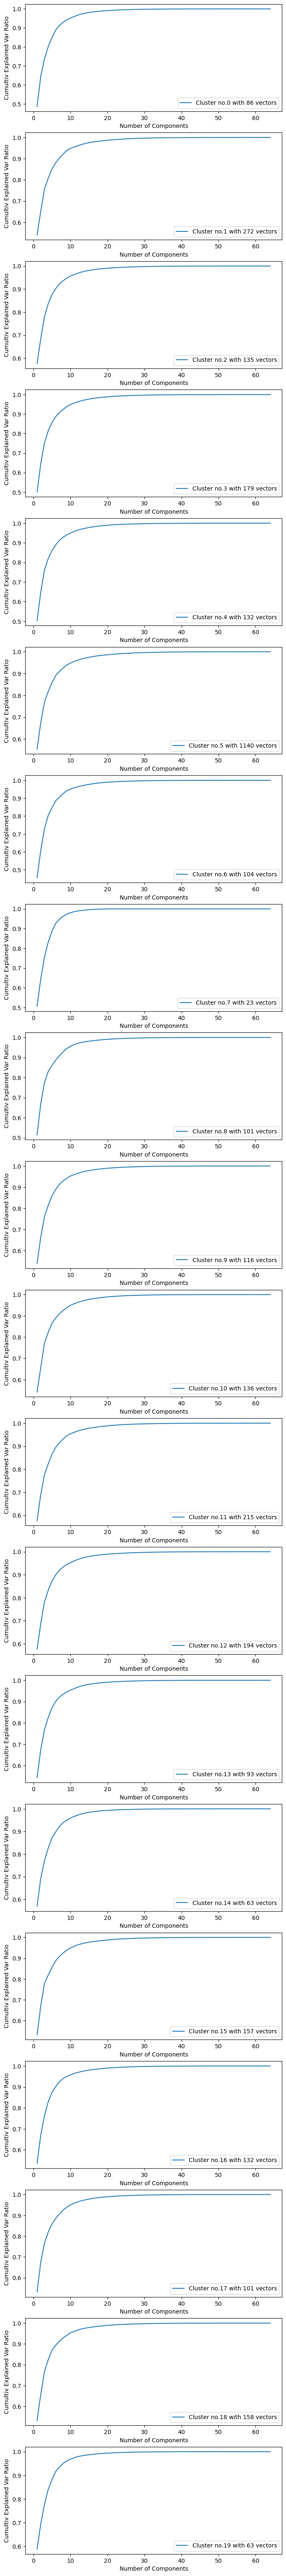

In [15]:
num_clusters = len(centered_clusters)
fig, axs = plt.subplots(nrows= num_clusters, ncols =1, figsize=(8,4* num_clusters))

#clusters_pcavectors and mean- a set basis(psi), one for each cluster
t_exp = 0.9
dynamic_psi = dict()
fixed_psi = dict()
dim_comp = 0.5
fixed_cut = int(dim_comp* np.square(tile_w))

for i, (cluster_key, points) in enumerate(centered_clusters.items()):
    cluster_pca, expln_var_cum, pca_vectors = pca_for_cluster(points)

    # find the index that reaches 0.9 cumsum variability
    cutidx = np.argmax(expln_var_cum >= t_exp)
    dynamic_basis = np.vstack((np.array([cluster_means[cluster_key]]), pca_vectors[:cutidx]))
    fixed_basis = np.vstack((np.array([cluster_means[cluster_key]]), pca_vectors[:fixed_cut]))

    # Add the dynamic_basis vectors describing the 0.9 variance
    dynamic_psi[cluster_key] = dynamic_basis

    # Add the fixed_basis vectors which are the 50% of the the basis vectors
    fixed_psi[cluster_key] = fixed_basis

    print('Cluster %d dynamic_basis vectors shape:'%(cluster_key), dynamic_basis.shape)
    print('Cluster compression when pruning %.2f variance is %.4f'%(t_exp, dynamic_basis.shape[0]/points.shape[0]))
    print('--------------------')
                      
    axs[i].plot(range(1, len(expln_var_cum) + 1), expln_var_cum, label='Cluster no.%d with %d vectors'%(cluster_key, points.shape[0]))
    axs[i].set_xlabel('Number of Components')
    axs[i].set_ylabel('Cumultiv Explained Var Ratio')
    axs[i].legend()

# plt.savefig('results/Patching_Image_%d.pdf'%(image_number))
plt.show()

Approximate $\hat{x}$ for each data point inside the cluster

In [16]:
# Approximate x_hat = Psi_k alpha; for each tile x_hat
def fit_to_basis(data_vectors, basis_vectors):
    """ 
    basis_vectors : an nxN array with a basis vector(N-dimensional) in each row 
    data_vectors : an mxN array with m examples of (N-dimensional) data.
    """ 
    projection_matrix = basis_vectors.T @ (np.linalg.pinv(basis_vectors @ basis_vectors.T) @ basis_vectors)
    approximations = data_vectors @ projection_matrix
    errors = np.linalg.norm(data_vectors - approximations , axis=1)
    # print(errors.shape)
    return approximations, errors

 cluster 0 has error after fitting: 
 dynamic basis selection: 99.8401 
 fixed top 0.50: 12.3509 
 ------ 
 cluster 1 has error after fitting: 
 dynamic basis selection: 100.6275 
 fixed top 0.50: 16.1788 
 ------ 
 cluster 2 has error after fitting: 
 dynamic basis selection: 110.1349 
 fixed top 0.50: 14.6576 
 ------ 
 cluster 3 has error after fitting: 
 dynamic basis selection: 103.6180 
 fixed top 0.50: 15.2679 
 ------ 
 cluster 4 has error after fitting: 
 dynamic basis selection: 100.1304 
 fixed top 0.50: 15.0133 
 ------ 
 cluster 5 has error after fitting: 
 dynamic basis selection: 100.3035 
 fixed top 0.50: 17.8734 
 ------ 
 cluster 6 has error after fitting: 
 dynamic basis selection: 97.1552 
 fixed top 0.50: 13.6713 
 ------ 
 cluster 7 has error after fitting: 
 dynamic basis selection: 96.2589 
 fixed top 0.50: 0.0000 
 ------ 
 cluster 8 has error after fitting: 
 dynamic basis selection: 93.8995 
 fixed top 0.50: 12.7616 
 ------ 
 cluster 9 has error after fittin

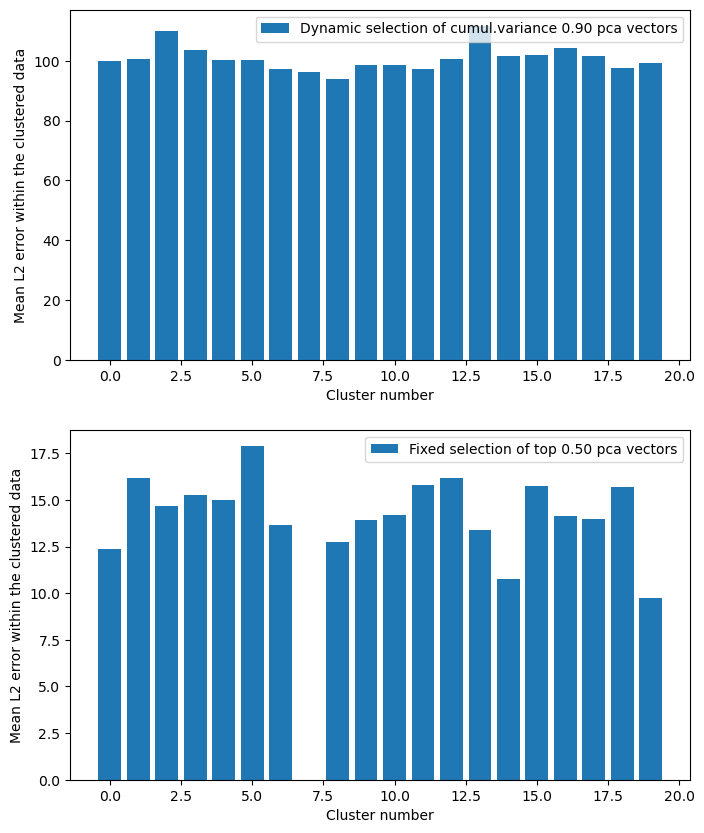

In [17]:
dyn_errors = []
fix_errors = []
for i, (cluster_key, points) in enumerate(clustered_data.items()):
    dyn_approx, dyn_errs = fit_to_basis(clustered_data[cluster_key], dynamic_psi[cluster_key])
    fix_approx, fix_errs = fit_to_basis(clustered_data[cluster_key], fixed_psi[cluster_key])
    dyn_errors.append(np.mean(dyn_errs))
    fix_errors.append(np.mean(fix_errs))
    print(" cluster %d has error after fitting: \n dynamic basis selection: %.4f \n fixed top %.2f: %.4f \n ------ "%(i, np.mean(dyn_errs), dim_comp, np.mean(fix_errs)))

# print(np.array(dyn_errors).shape)

fig, axs = plt.subplots(nrows= 2, ncols =1, figsize=(8,10))
axs[0].bar(np.array(range(num_clusters)), dyn_errors, label='Dynamic selection of cumul.variance %.2f pca vectors'%(t_exp))
axs[0].set_xlabel('Cluster number')
axs[0].set_ylabel('Mean L2 error within the clustered data')
axs[0].legend()

axs[1].bar(range(num_clusters), fix_errors, label='Fixed selection of top %.2f pca vectors'%(dim_comp))
axs[1].set_xlabel('Cluster number')
axs[1].set_ylabel('Mean L2 error within the clustered data')
axs[1].legend()

### Approximate $\hat{x}$ for each $x$ datapoint in the original tiles1d so that I can recreate the image.

In [18]:
print('1D data array shape:',im_tiles1d.shape)
print('cluster indices shape',cluster_indices.shape)


1D data array shape: (3600, 64)
cluster indices shape (3600,)


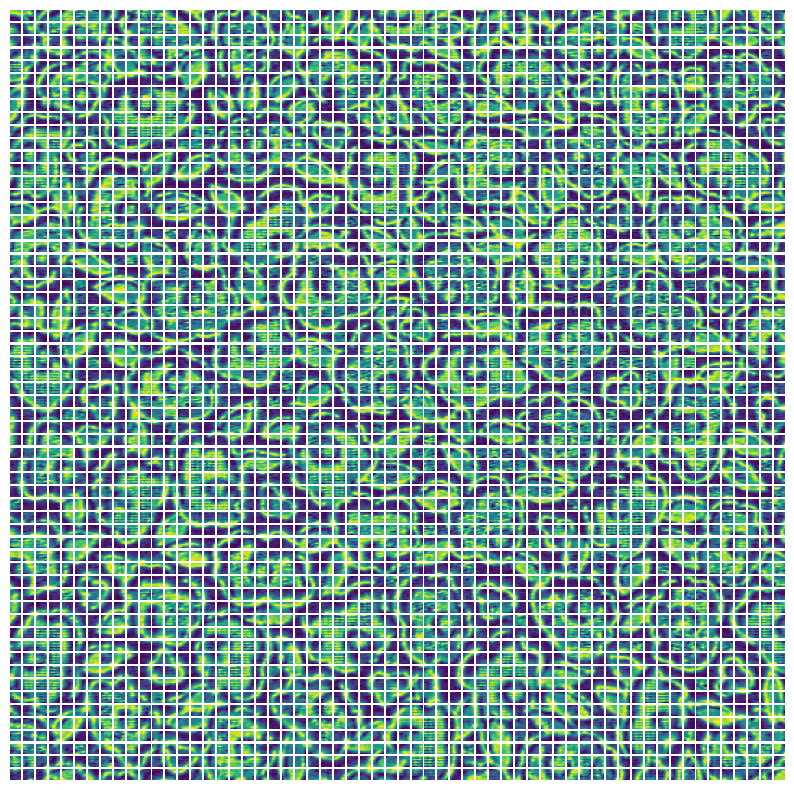

In [21]:
def visualise_approx(im_tiles1d, cluster_indices):
    approx_data1d = np.zeros_like(im_tiles1d)
    error_data = np.zeros_like(im_tiles1d)
    for i in range(len(cluster_indices)):
        fix_approx, fix_errs = fit_to_basis(im_tiles1d[i][np.newaxis,:],fixed_psi[cluster_indices[i]])
        approx_data1d[i] = fix_approx
        error_data[i] = fix_errs

    num_tiles_x = int(np.sqrt(approx_data1d.shape[0]))
    num_tiles_y = int(np.sqrt(approx_data1d.shape[0]))
    tile_width = tile_w
    tile_height = tile_w
    approx_data2d = approx_data1d.reshape(num_tiles_x, num_tiles_x, tile_width, tile_height)
    approx_image = approx_data2d.transpose(0, 2, 1, 3).reshape(num_tiles_y*tile_height, num_tiles_x*tile_width)

    return approx_data2d, approx_image

approx_data2d, approx_image = visualise_approx(im_tiles1d, cluster_indices)
visualize_tiles(approx_data2d)

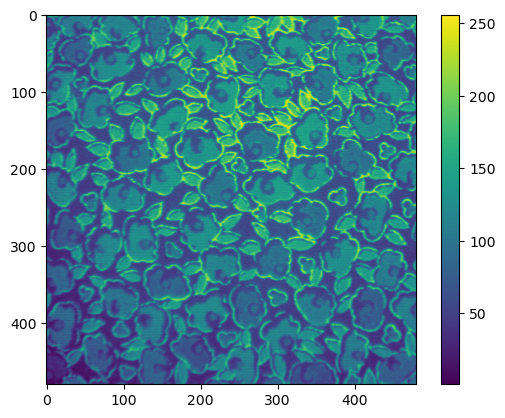

In [22]:
plt.imshow(approx_image)
plt.colorbar()
plt.show()

In [23]:
np.mean(np.square(approx_image - image))

11.80913333108355

### One function to rule them all :p

In [24]:
def clusterdenoising(image, tile_w, num_clusters, t_ratio=0.5):
    """
    Inputs: An image to be denoised, tile width, number of PCA clusters
    Outputs: A cluster approximated image using to t_ratio of PCA vectors
    """
    im_tiles2d, im_tiles1d = return_tiles(image, tile_w)
    im_tiles1d = im_tiles1d.astype(float)

    centroids, _ = kmeans(im_tiles1d, num_clusters)
    # print('data dimensions:', im_tiles1d.shape)
    # print('number of clusters:', num_clusters)
    # print('centroids shape:', centroids.shape)

    #vector quatization
    cluster_indices, _ = vq(im_tiles1d, centroids)
    # print('cluster_indices shape:', cluster_indices.shape)

    clustered_data, cluster_medoids, cluster_means = get_cluster_medoids(im_tiles1d, cluster_indices)
    # print ('keys of clustered_data:' ,clustered_data.keys())
    # print ('clustered_data[0] has shape' ,np.array(clustered_data[0]).shape)
    # print('cluster_medoids[0]  has shape', cluster_medoids[0].shape)
    # print ('cluster_means[0] has shape' , cluster_means[0].shape)

    centered_clusters = get_centered_clusters(clustered_data, cluster_means)

    t_exp = 0.9
    dynamic_psi = dict()
    fixed_psi = dict()
    dim_comp = t_ratio
    fixed_cut = int(dim_comp* np.square(tile_w))

    for i, (cluster_key, points) in enumerate(centered_clusters.items()):
        cluster_pca, expln_var_cum, pca_vectors = pca_for_cluster(points)

        # find the index that reaches 0.9 cumsum variability
        cutidx = np.argmax(expln_var_cum >= t_exp)
        dynamic_basis = np.vstack((np.array([cluster_means[cluster_key]]), pca_vectors[:cutidx]))
        fixed_basis = np.vstack((np.array([cluster_means[cluster_key]]), pca_vectors[:fixed_cut]))

        # Add the dynamic_basis vectors describing the 0.9 variance
        dynamic_psi[cluster_key] = dynamic_basis

        # Add the fixed_basis vectors which are the 50% of the the basis vectors
        fixed_psi[cluster_key] = fixed_basis


    approx_data2d, approx_image = visualise_approx(im_tiles1d, cluster_indices)
    return approx_data2d, approx_image

In [25]:
_ , approx_image = clusterdenoising(image,tile_w=8,num_clusters=20,t_ratio=0.5)

In [26]:
def compareNLM(image_number):
    image = cv2.imread(f"Dataset/Image{image_number}.png")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    mindim = np.min(image.shape)
    image = image[:mindim, :mindim]

    # Define Gaussian noise levels
    noise_levels = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]

    # Create a plot to display images
    plt.figure(figsize=(15, 8))

    #NLM args
    patch_kw = dict(patch_size=8,      # 8x8 patches
                    patch_distance=6,  # 13x13 search area
                    channel_axis=-1)

    mse_NLM = []
    mse_ours= []

    # Plot noisy images and denoised images
    for i, noise_level in enumerate(noise_levels):
        # Add Gaussian noise to the original image
        noisy_image = np.uint8(np.clip(image + np.random.normal(scale=noise_level, size=image.shape), 0, 255))
        
        # Denoise the noisy image (replace this with your denoising algorithm)
        _,ours_denoised = clusterdenoising(noisy_image,tile_w=8,num_clusters=20,t_ratio=0.5)

        #NLM Slow
        noisy_image_NLM = noisy_image[:,:, np.newaxis]
        sigma_est = np.mean(estimate_sigma(noisy_image_NLM, channel_axis=-1))
        NLM_denoised = (denoise_nl_means(noisy_image_NLM, h=0.7 * sigma_est, fast_mode=False,
                            **patch_kw) * 255).astype(np.uint8)

        mse_NLM.append(np.mean(np.square(NLM_denoised-image)))
        mse_ours.append(np.mean(np.square(ours_denoised-image)))

        # Plot the noisy image
        plt.subplot(3, 10, i + 1)
        plt.imshow(noisy_image)
        plt.title(f'Noisy (σ={noise_level})')
        plt.axis('off')

        # Plot the denoised image
        plt.subplot(3, 10, i + 11)
        plt.imshow(NLM_denoised)
        plt.title(f'AfterNLM (σ={noise_level})')
        plt.axis('off')
        
        # Plot the denoised image
        plt.subplot(3, 10, i + 21)
        plt.imshow(ours_denoised)
        plt.title(f'Ours (σ={noise_level})')
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('results/LASSO_Spectral_OursvsNLM_Image_%d_GaussianNoise.png'%(image_number))
    
    plt.figure(figsize=(10, 6))
    plt.plot(noise_levels, mse_NLM, marker='o', label='NLM')
    plt.plot(noise_levels, mse_ours, marker='o', label='Ours')
    plt.title('MSE Losses for Denoising Methods')
    plt.xlabel('Noise Level')
    plt.ylabel('MSE Loss')
    plt.xticks(noise_levels)
    plt.grid(True)
    plt.legend()
    plt.savefig('results/LASSO_Spectral_OursvsNLM_Image_%d_GaussianNoise_MSE.png'%(image_number))
    

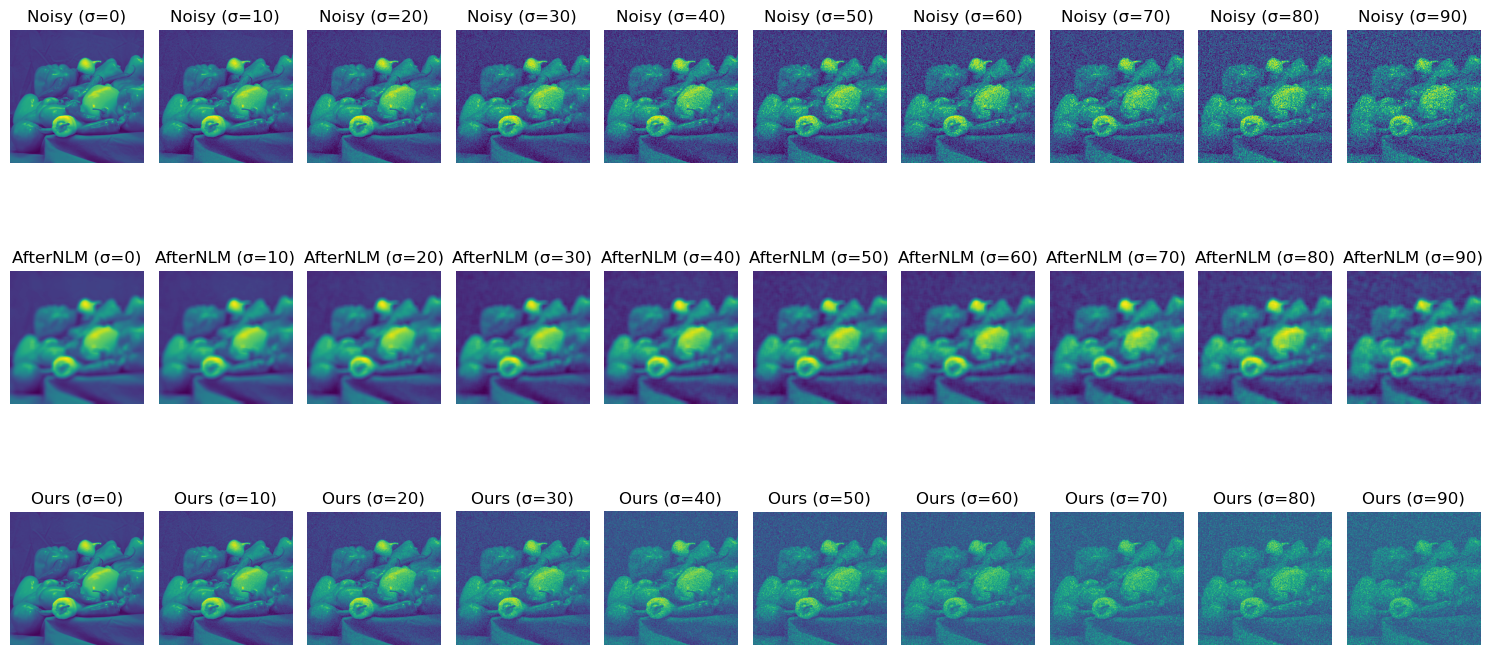

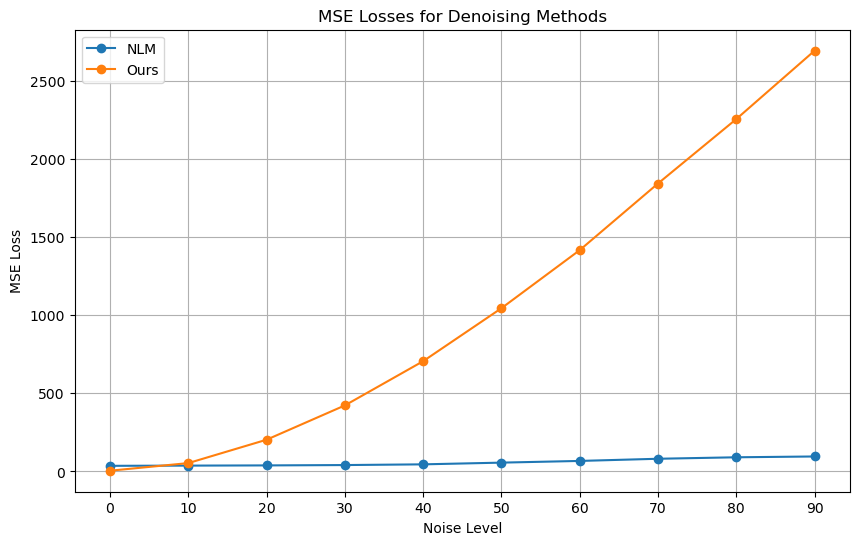

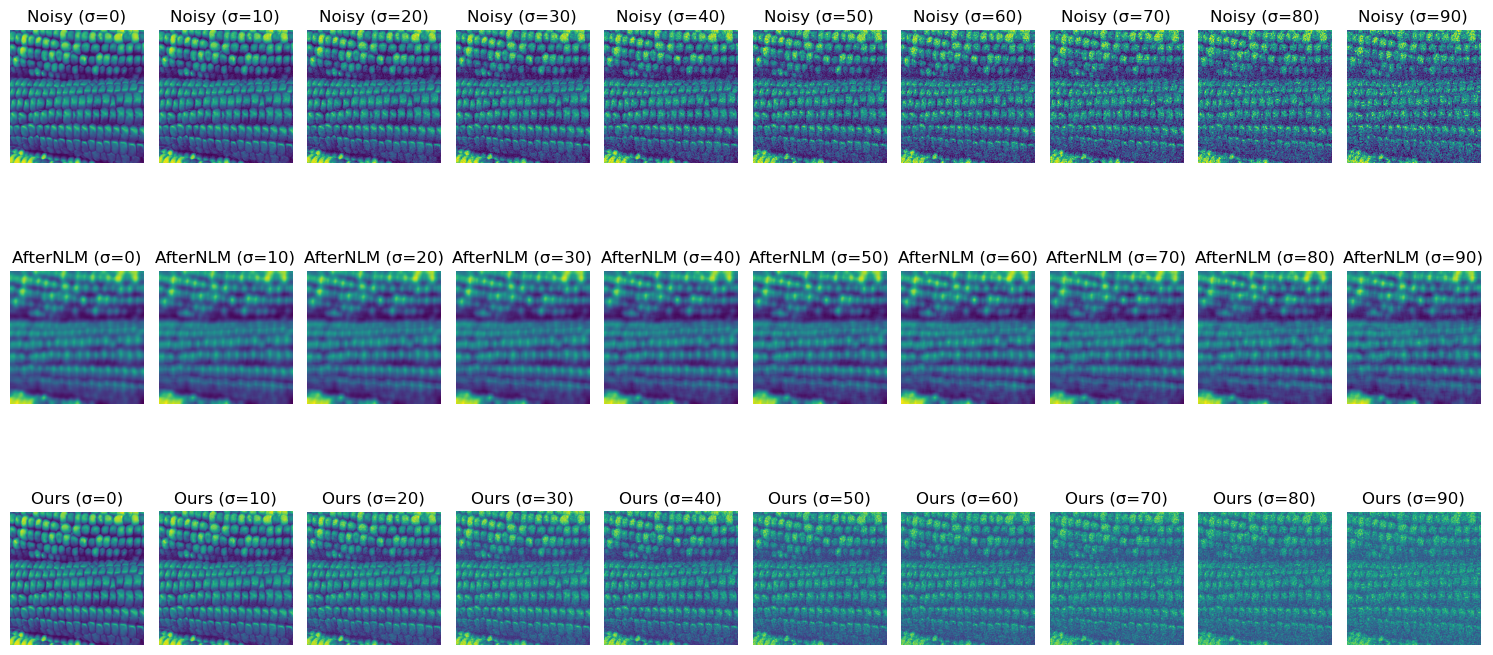

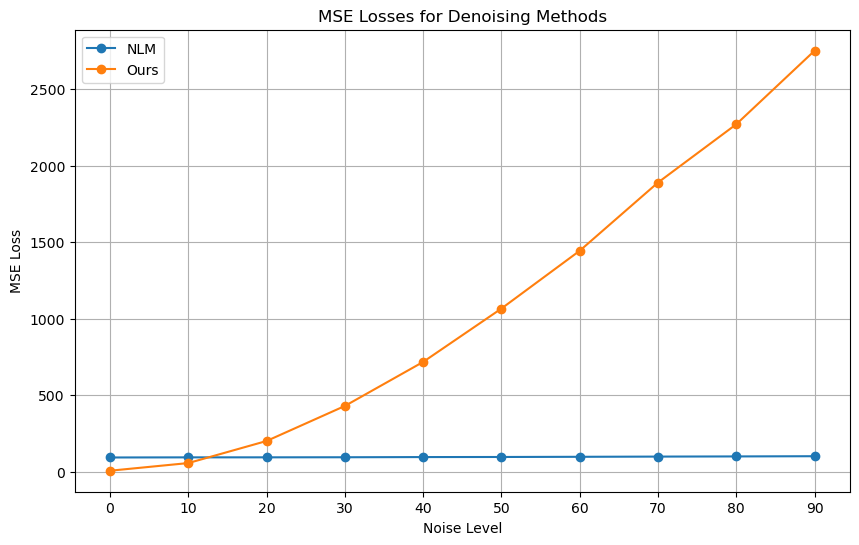

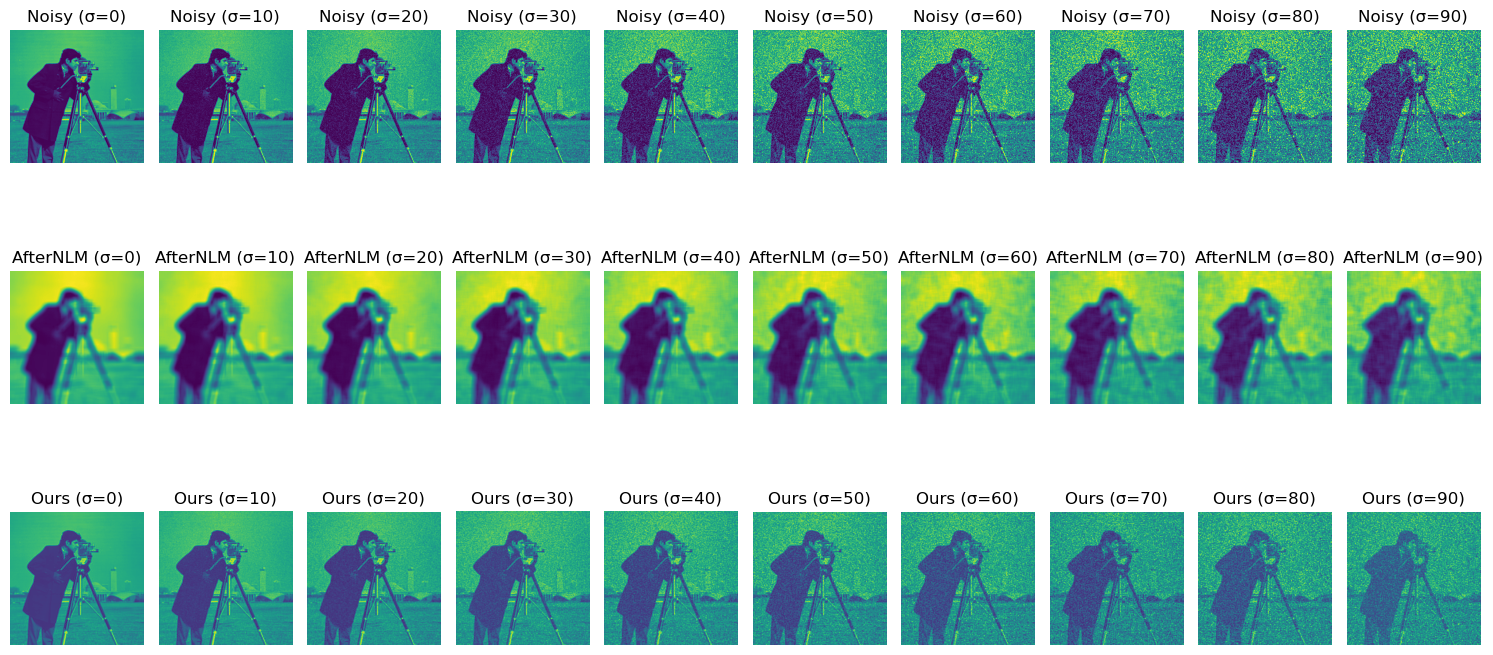

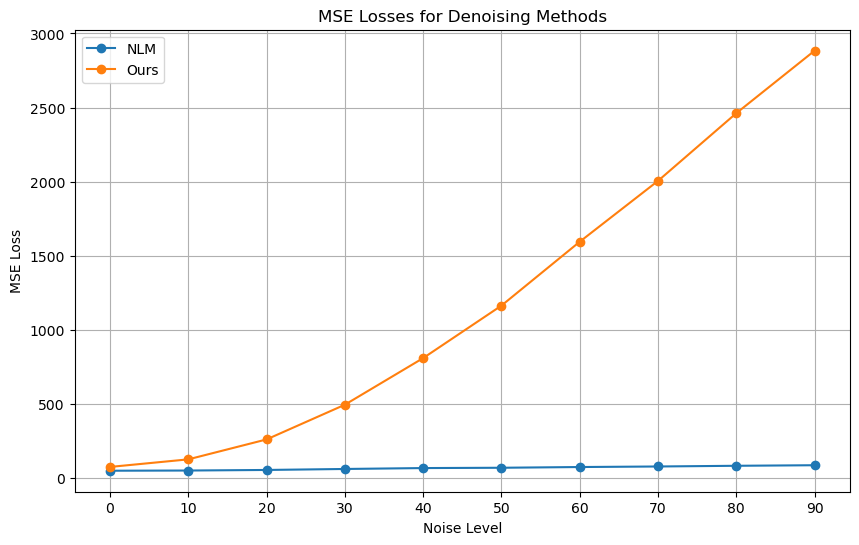

In [27]:
for image_num in range(1,4):
    compareNLM(int(image_num))

In [28]:
#Sanity check
#NLM args
patch_kw = dict(patch_size=8,      # 5x5 patches
                patch_distance=6,  # 13x13 search area
                channel_axis=-1)
noisy_image = np.uint8(np.clip(image + np.random.normal(scale=50, size=image.shape), 0, 255))      
noisy_image_NLM = noisy_image[:,:, np.newaxis]
sigma_est = np.mean(estimate_sigma(noisy_image_NLM, channel_axis=-1))
NLM_denoised = denoise = (denoise_nl_means(noisy_image_NLM, h=1.5 * sigma_est, fast_mode=False,
                    **patch_kw) *255).astype(np.uint8)

print(np.mean(np.square(NLM_denoised-image)))

95.60990017361111
